# CIFAR10 ZCA Whitening

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

In [2]:
_ = torch.manual_seed(42)

## Loading and Visualizing CIFAR10

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

cifar10 = CIFAR10(
    root='../cifar10/',
    train=True,
    download=True,
    transform=transform)

dataloader = DataLoader(cifar10, batch_size=1)


labels = cifar10.classes
labels_to_idx = cifar10.class_to_idx
print(labels)
print(labels_to_idx)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


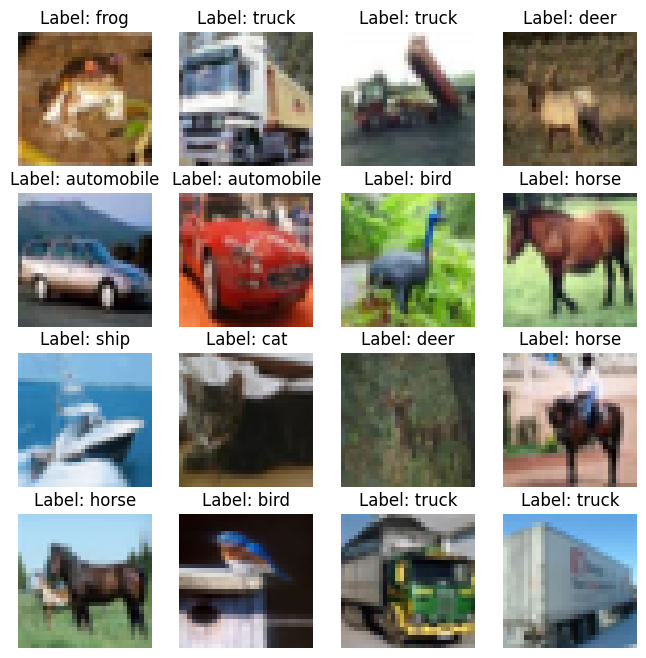

In [4]:
N = 4
size = (8, 8)
_, ax = plt.subplots(nrows=N, ncols=N, figsize=size)
ax = ax.flatten()

"""
image.shape                             [1, 3, 32, 32]
image.squeeze().shape                   [3, 32, 32]
image.squeeze().permute(2, 1, 0).shape  [32, 32, 3]
"""
for n, (image, label) in enumerate(dataloader):
    if n == N**2: break 
    img = image.squeeze().permute(1, 2, 0).numpy()
    label = labels[label.item()]
    
    ax[n].imshow(img)
    ax[n].set_title(f'Label: {label}')
    ax[n].axis('off')

## Applying Whiteinig

In [5]:
data = cifar10.data    # cifar10 training images
data = data / 255.0

print(f'Shape of data: {data.shape}')

print(f'data.min() = {data.min()}')
print(f'data.max() = {data.max()}')

X = data.reshape(-1, 3 * 32 * 32)
print(f'Shape of X: {X.shape}')

mean = X.mean(axis=0)
print(f'Shape of mean: {mean.shape}')

# mean subtraction per-pixel for all images
X_ = X - mean

# calculate covariance matrix
cov = np.cov(X_, rowvar=False)
print(f'Shape of cov: {cov.shape}')

Shape of data: (50000, 32, 32, 3)
data.min() = 0.0
data.max() = 1.0
Shape of X: (50000, 3072)
Shape of mean: (3072,)
Shape of cov: (3072, 3072)


In [6]:
# magic
U, S, V = np.linalg.svd(cov)
print(f'Shape of U: {U.shape}')
print(f'Shape of S: {S.shape}')
print(f'Shape of V: {V.shape}')

Shape of U: (3072, 3072)
Shape of S: (3072,)
Shape of V: (3072, 3072)


In [7]:
epsilon = 1e-2
X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_.T).T
print(f'Shape of X_zca: {X_ZCA.shape}')

Shape of X_zca: (50000, 3072)


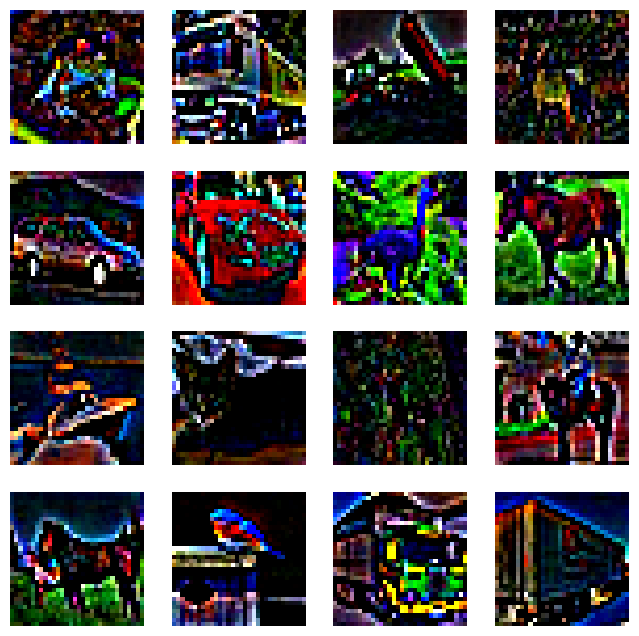

In [8]:
N = 4
size = (8, 8)
_, ax = plt.subplots(nrows=N, ncols=N, figsize=size)
ax = ax.flatten()

"""
image.shape                             [1, 3072]
image.reshape(32, 32, 3).shape          [32, 32, 3]
"""
for n, image in enumerate(X_ZCA):
    if n == N**2: break 
    image = np.clip(image, 0, 1)
    image = image.reshape(32, 32, 3)
    
    ax[n].imshow(image)
    ax[n].axis('off')

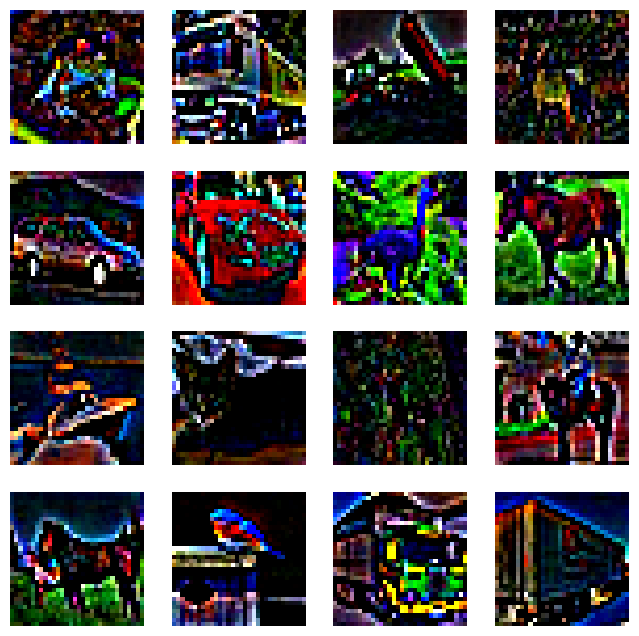

In [9]:
X = X_ZCA.reshape(50000, 32, 32, 3).transpose(0, 3, 1, 2)

N = 4
size = (8, 8)
_, ax = plt.subplots(nrows=N, ncols=N, figsize=size)
ax = ax.flatten()

"""
image.shape                             [1, 3072]
image.reshape(32, 32, 3).shape          [32, 32, 3]
"""
for n, image in enumerate(X):
    if n == N**2: break 
    image = np.clip(image, 0, 1)
    image = image.transpose(1, 2, 0)
    ax[n].imshow(image)
    ax[n].axis('off')

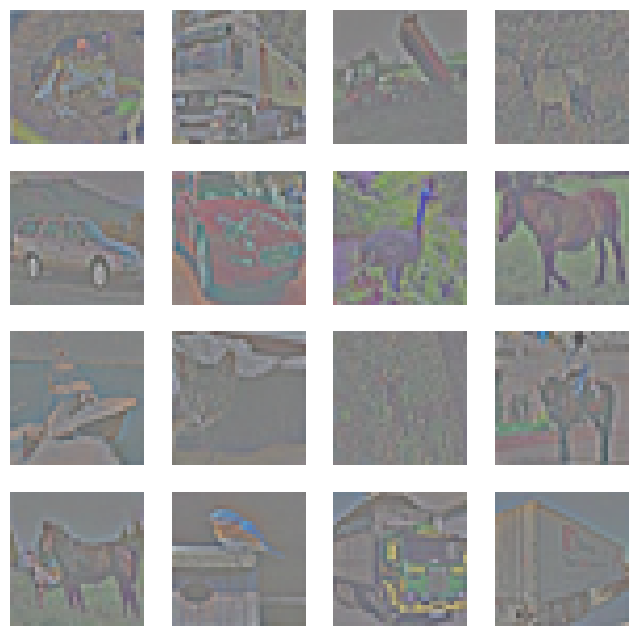

In [10]:
X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())

N = 4
size = (8, 8)
_, ax = plt.subplots(nrows=N, ncols=N, figsize=size)
ax = ax.flatten()

"""
image.shape                             [1, 3072]
image.reshape(32, 32, 3).shape          [32, 32, 3]
"""
for n, image in enumerate(X_ZCA_rescaled):
    if n == N**2: break 
    image = image.reshape(32, 32, 3)
    
    ax[n].imshow(image)
    ax[n].axis('off')